# Scaling collpase cleaned

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from fssa import quality
from tqdm import tqdm
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
import fssa

In [27]:
def load_data(rho, Ls= np.arange(8,16,2).astype(float), skip_initial=5):
    
    Y = np.zeros((len(Ls),len(rho)))
    dY = np.zeros((len(Ls),len(rho)))
    for index, L in enumerate(Ls):
        data = np.load('data/cluster/'+'2nn-{}-combined.npy'.format(int(L)))
        Y[index] = np.mean(data,axis=0)
        dY[index] = np.std(data,axis=0)

    rho = rho[skip_initial:]
    Y = Y[:,skip_initial:]
    dY = dY[:,skip_initial:]
    return rho, Y, dY


def x_func(rho, rho_c, l, nu):
    return np.power(l, 1./nu) * (rho-rho_c)

def x_BKT(rho, rho_c, l, nu):
    a = nu
    return l*np.exp(-a/np.sqrt(abs(rho-rho_c)))

def y_func(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y

def goal_function(args = [3.,2.2,1.2]):
    rho_c, nu, zeta = args[0],  args[1],  args[2] 
    #XX = x_func(rho=rho_mesh_local, rho_c=rho_c, l=l_mesh_local ,nu=nu) 
    x = x_BKT(rho=rho_mesh_local, rho_c=rho_c, l=l_mesh_local ,nu=nu) 
    y = y_func(y=Y, l=l_mesh_local, zeta=zeta, nu=nu)
    dy = y_func(y=dY, l=l_mesh_local, zeta=zeta, nu=nu)
    
    # sorting for BKT
    sorting_index = np.argsort(x)[0]
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]    
    return quality(x,y,dy)
    
def scaledata(l, rho, a, da, rho_c, nu, zeta):
    r'''
    for DOCS see fssa
    '''
    # l should be 1-D array_like
    l = np.asanyarray(l)
    if l.ndim != 1:
        raise ValueError("l should be 1-D array_like")
    # rho should be 1-D array_like
    rho = np.asanyarray(rho)
    if rho.ndim != 1:
        raise ValueError("rho should be 1-D array_like")
    # a should be 2-D array_like
    a = np.asanyarray(a)
    if a.ndim != 2:
        raise ValueError("a should be 2-D array_like")
    # a should have shape (l.size, rho.size)
    if a.shape != (l.size, rho.size):
        raise ValueError("a should have shape (l.size, rho.size)")
    # da should be 2-D array_like
    da = np.asanyarray(da)
    if da.ndim != 2:
        raise ValueError("da should be 2-D array_like")
    # da should have shape (l.size, rho.size)
    if da.shape != (l.size, rho.size):
        raise ValueError("da should have shape (l.size, rho.size)")
    # rho_c should be in range
    if rho_c > rho.max() or rho_c < rho.min():
        warnings.warn("rho_c is out of range", RuntimeWarning)

    # rho_c, nu, and zeta should be float
    rho_c = float(rho_c)
    nu = float(nu)
    zeta = float(zeta)   

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    
    #x = np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c) ## old
    x = l_mesh*np.exp(-1.4/np.sqrt(abs(rho_mesh-rho_c)))  ### This 1.4 is taking from mendes santos :/
    y = np.power(l_mesh, - zeta / nu) * a
    dy = np.power(l_mesh, - zeta / nu) * da

    sorting_index = np.argsort(x)[0]
    
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]

    return ScaledData(x, y, dy)

In [29]:
rho = np.linspace(0.1,6.1,31)
rho, y, dy = load_data(rho)

100%|██████████| 10000/10000 [02:37<00:00, 63.68it/s]


Text(0, 0.5, 'quality')

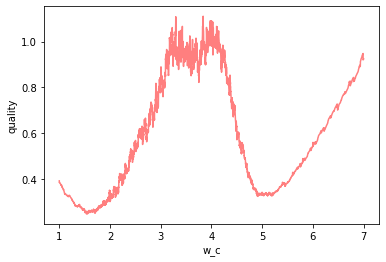

In [12]:
out = []
rs = np.linspace(1,7,10000)
for r in tqdm(rs):
    out.append(goal_function(r,2,2))
plt.plot(rs,out, c='r', alpha=.5)
plt.xlabel('$W_c$', fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.show()

In [31]:
fssa.autoscale(Ls, rho, y, dy, 3.6,2.,2., 1)

           dnu: 1.2761443204687717
          drho: nan
         dzeta: 2.3209718565489075
        errors: array([       nan, 1.27614432, 2.32097186])
 final_simplex: (array([[3.91993678, 1.7985039 , 1.7442203 ],
       [3.9151196 , 1.80343237, 1.75199902],
       [3.92285265, 1.80215994, 1.74215271],
       [3.91943889, 1.80470511, 1.75072343]]), array([0.06940015, 0.06940788, 0.06941019, 0.06941343]))
           fun: 0.06940015457037921
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 43
            nu: 1.7985038970242853
           rho: 3.9199367832344016
        status: 0
       success: True
         varco: array([[-9.96435222, -4.76961027, -2.81822282],
       [-4.76961027,  1.62854433,  3.47746285],
       [-2.81822282,  3.47746285,  5.38691036]])
             x: array([3.91993678, 1.7985039 , 1.7442203 ])
          zeta: 1.74422030018006